# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [2]:
df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

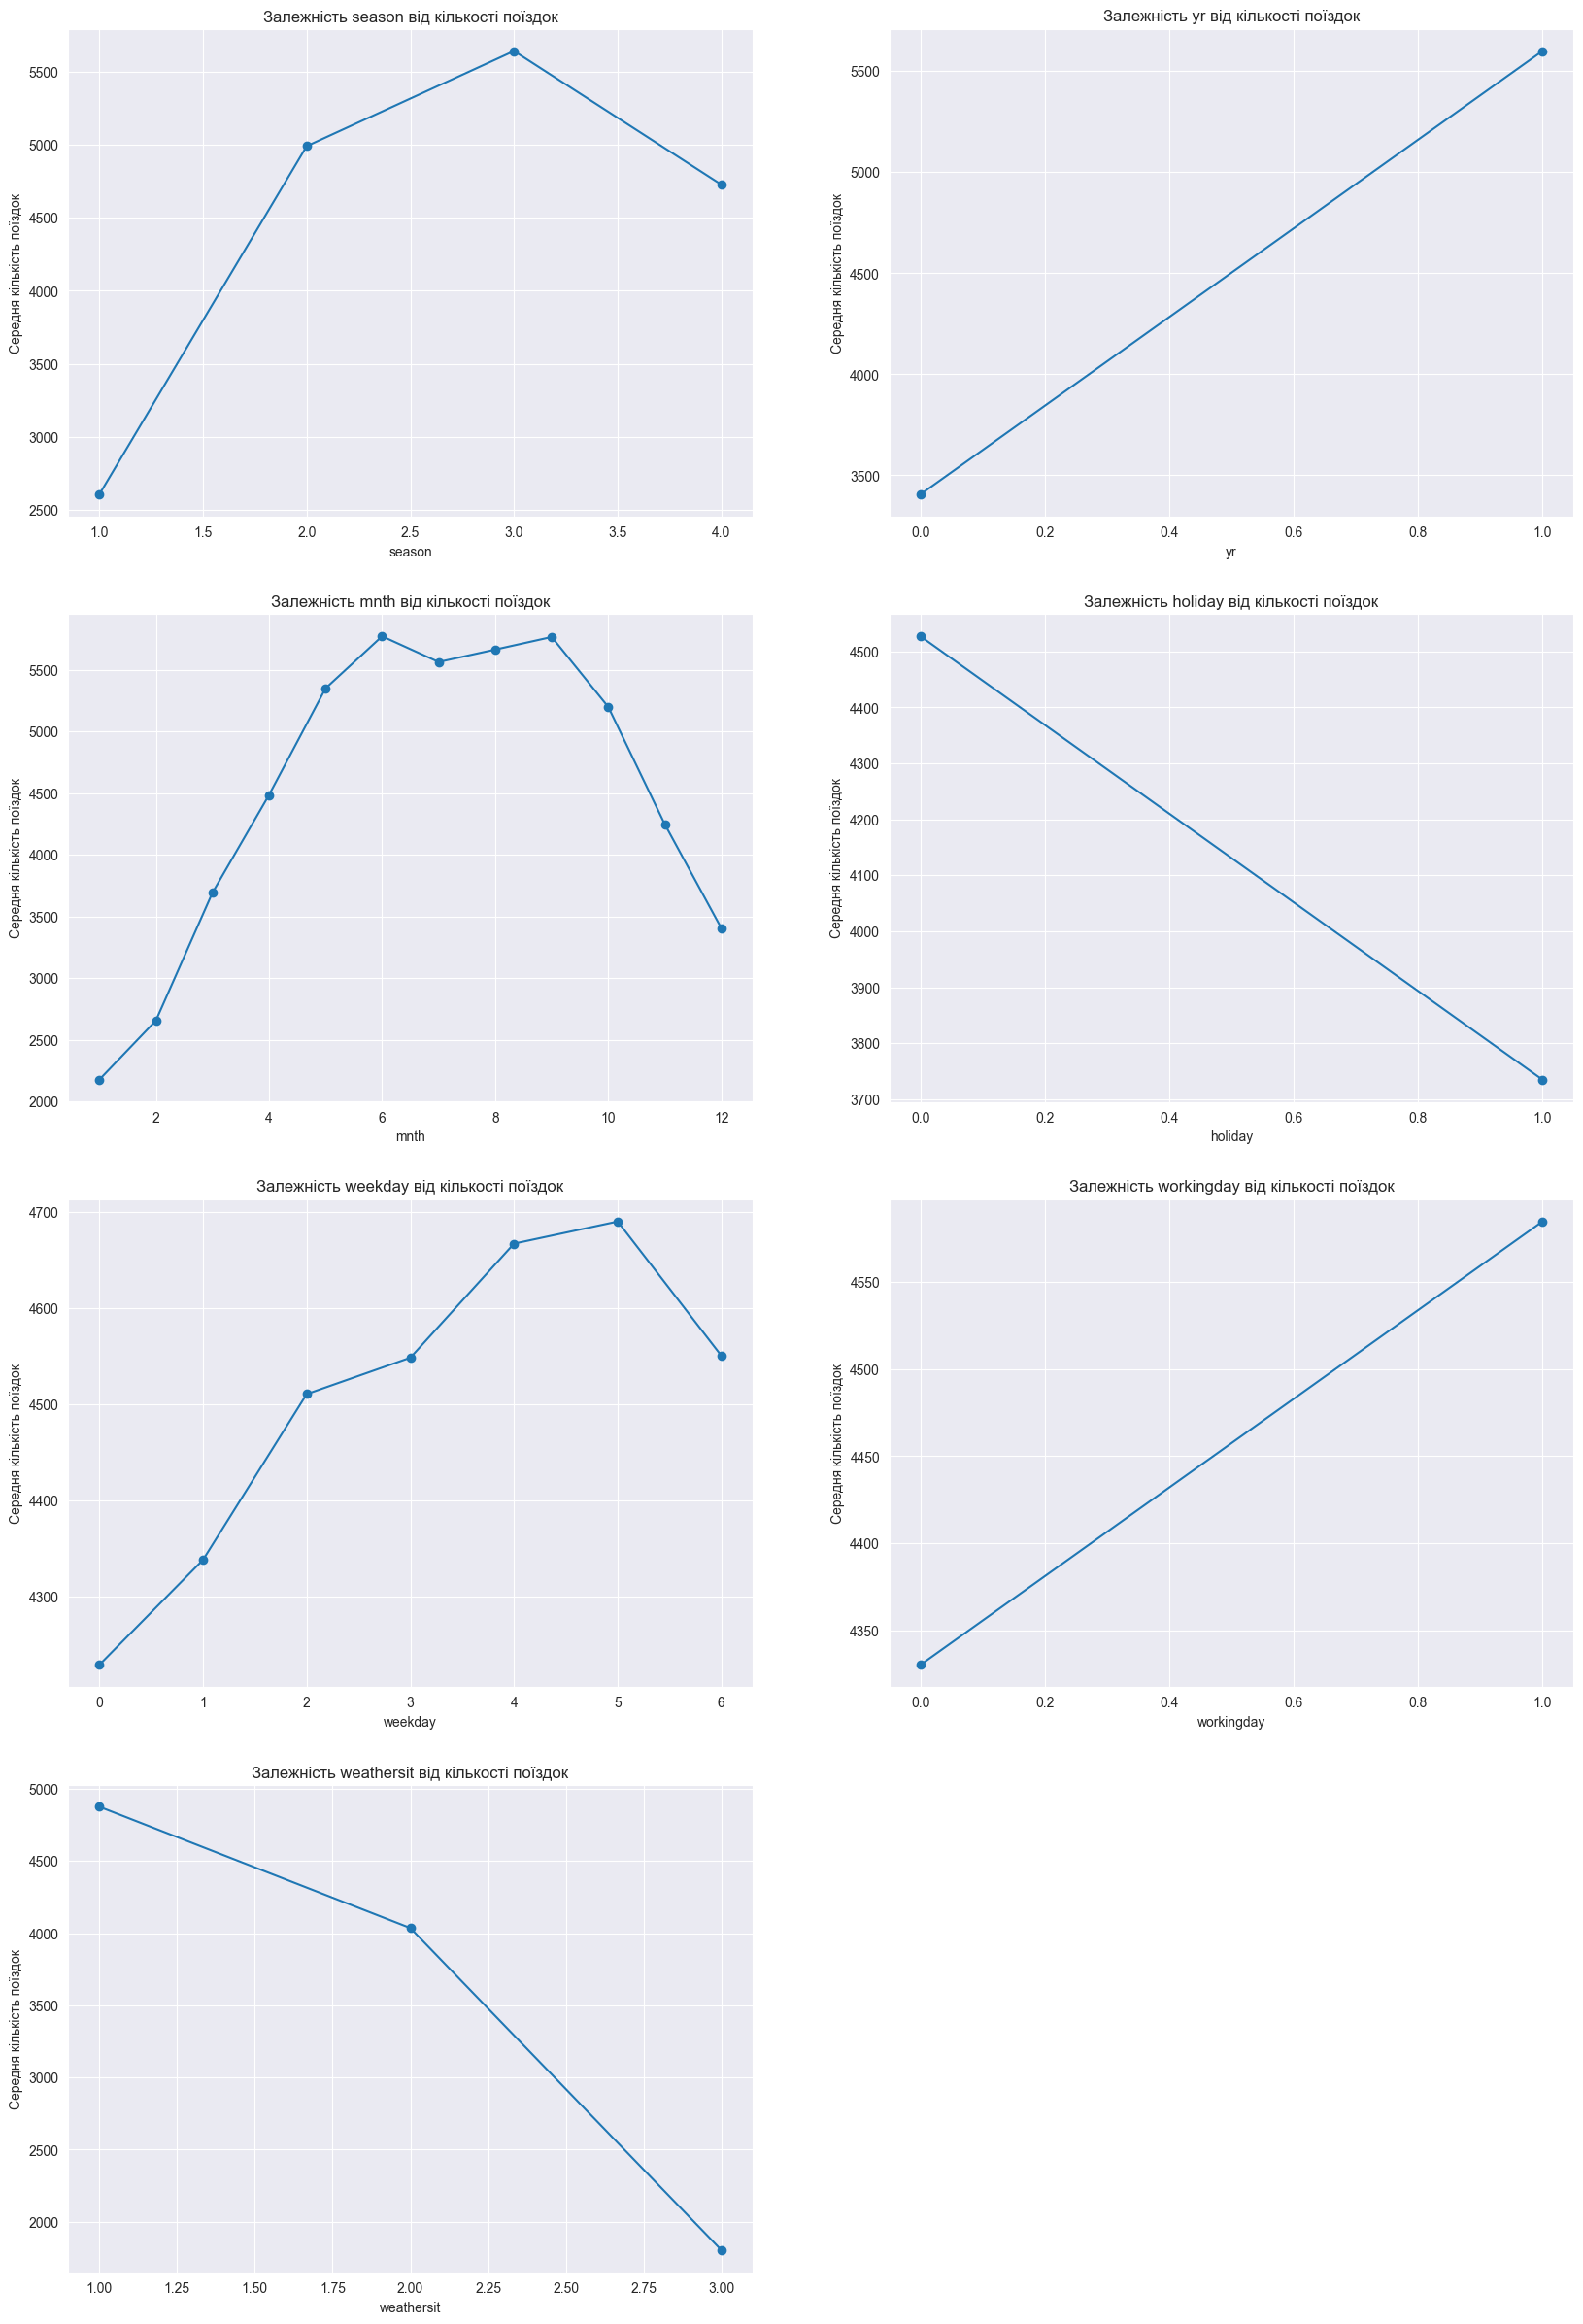

In [3]:
attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

plt.figure(figsize=(20, 30))

for i, attribute in enumerate(attributes, 1):

    cnt_per_attribute = df.groupby(attribute)['cnt'].mean()
    
    plt.subplot(4, 2, i)
    plt.plot(cnt_per_attribute.index, cnt_per_attribute.values, marker='o')
    plt.title(f'Залежність {attribute} від кількості поїздок')
    plt.xlabel(attribute)
    plt.ylabel('Середня кількість поїздок')

plt.show()

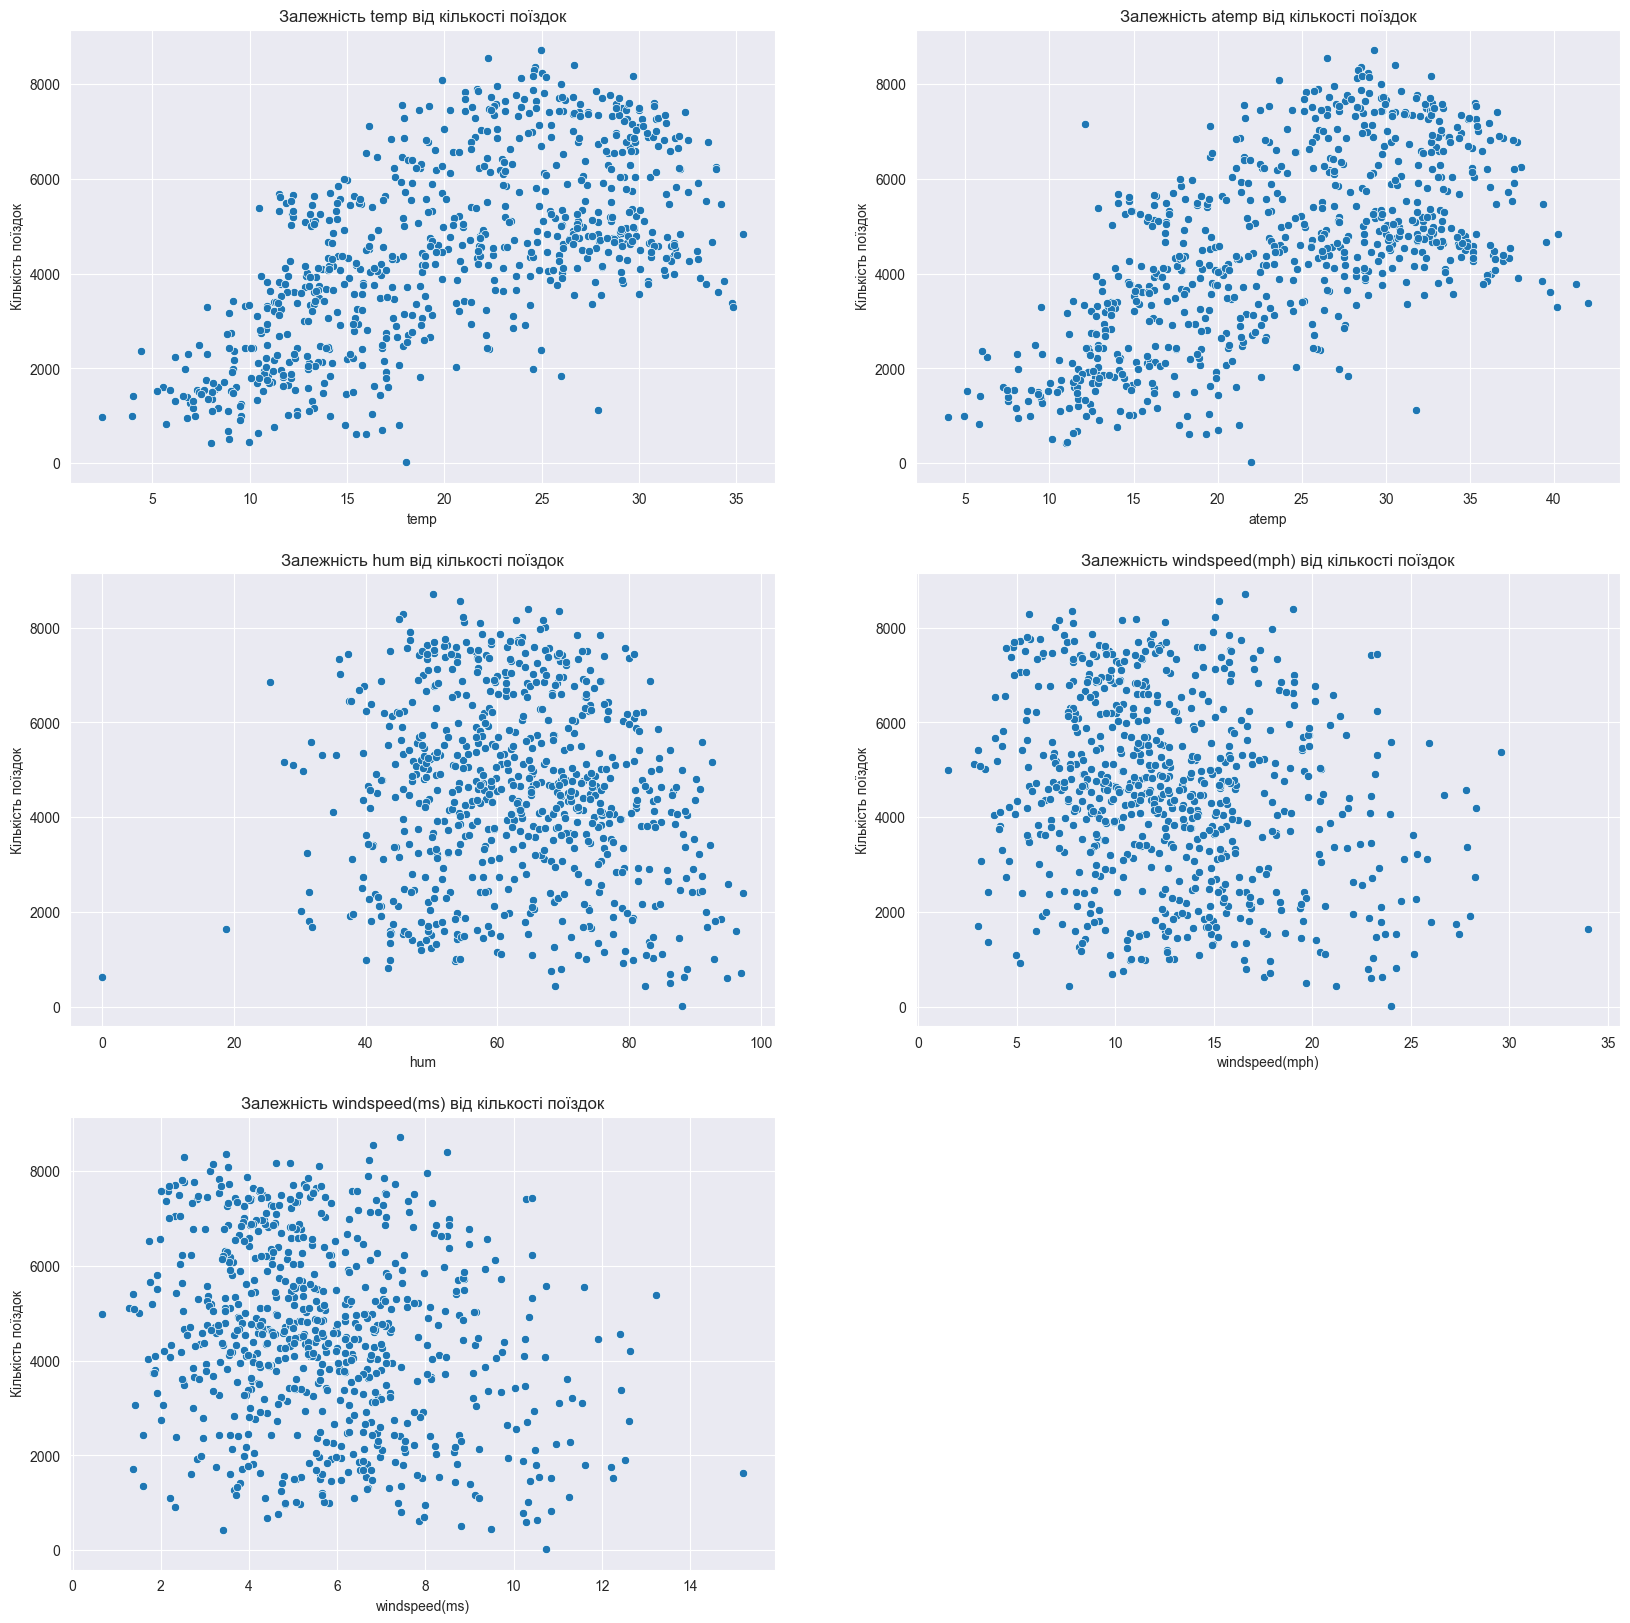

In [4]:
attributes_2 = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

plt.figure(figsize=(20, 20))

for i, attribute in enumerate(attributes_2, 1):

    plt.subplot(3, 2, i)
    sns.scatterplot(x=attribute, y='cnt', data=df)
    plt.title(f'Залежність {attribute} від кількості поїздок')
    plt.xlabel(attribute)
    plt.ylabel('Кількість поїздок')

plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

1.На графіку залежності від місяця помітна сезонність: кількість прокатів зростає навесні і досягає піку влітку, потім знижується восени і знову падає взимку
2.1 yr: кількість прокатів суттєво зросла з 2011 року до 2012 року,
2.2 workingday: кількість прокатів зростає в робочі дні порівняно з неробочими.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

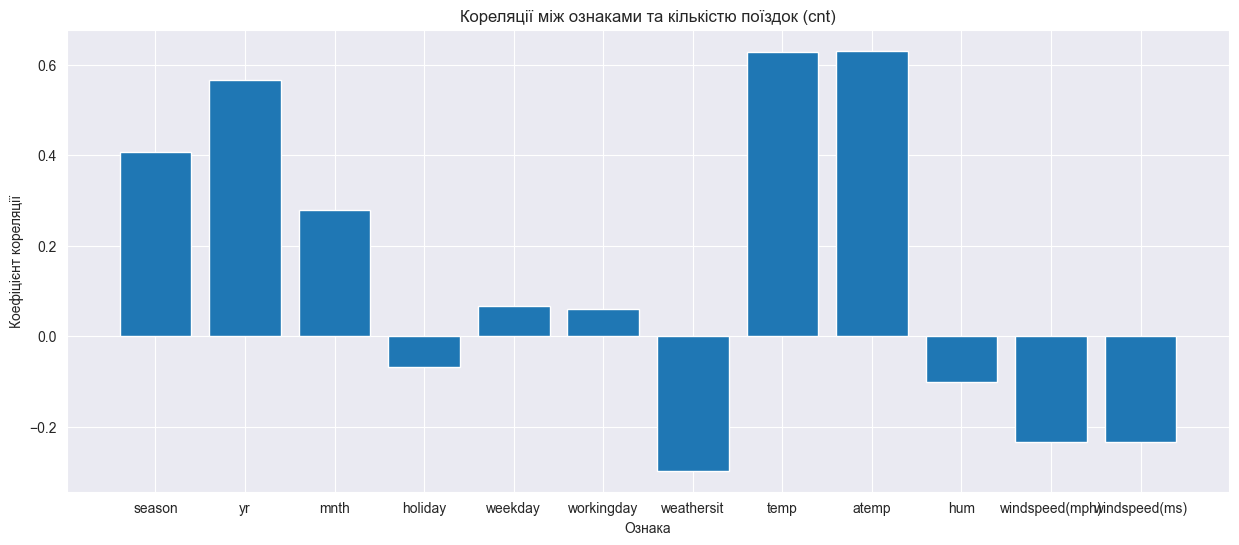

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

In [5]:
features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 
            'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

correlations = df[features].corrwith(df['cnt'])

plt.figure(figsize=(15, 6))
plt.bar(correlations.index, correlations.values)
plt.title('Кореляції між ознаками та кількістю поїздок (cnt)')
plt.ylabel('Коефіцієнт кореляції')
plt.xlabel('Ознака')
plt.grid(True)
plt.show()

correlations

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

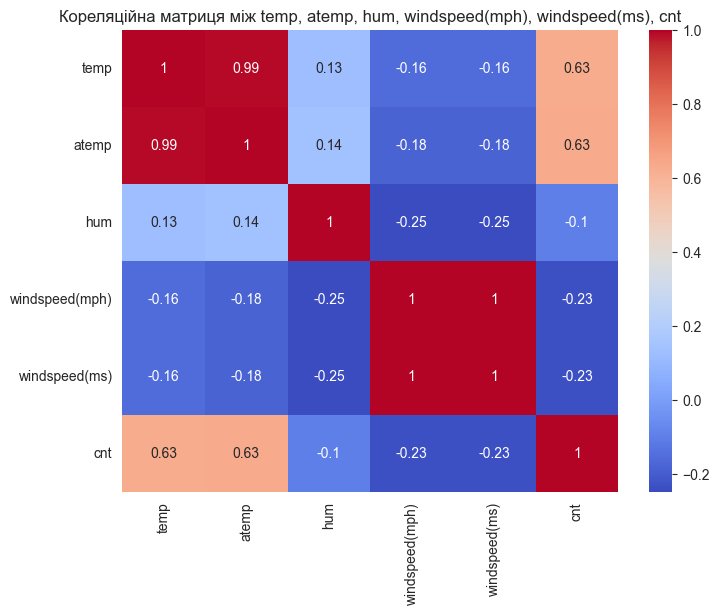

In [6]:
features_2 = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

correlation_matrix = df[features_2].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Кореляційна матриця між temp, atemp, hum, windspeed(mph), windspeed(ms), cnt')
plt.show()

На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [7]:
mean_values = df.mean()
mean_values

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [9]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)
weights = model.coef_
weights

array([ 5.70863642e+02,  1.02196042e+03, -1.41300633e+02, -8.67576047e+01,
        1.37227258e+02,  5.63898036e+01, -3.30227183e+02,  3.67479903e+02,
        5.85552180e+02, -1.45615523e+02,  1.24543563e+13, -1.24543563e+13])

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [11]:
for feature, weight in zip(df.columns[:-1], weights):
    print(f"{feature}: {weight:.5f}")

season: 570.86364
yr: 1021.96042
mnth: -141.30063
holiday: -86.75760
weekday: 137.22726
workingday: 56.38980
weathersit: -330.22718
temp: 367.47990
atemp: 585.55218
hum: -145.61552
windspeed(mph): 12454356291009.72656
windspeed(ms): -12454356291208.18750


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [12]:
from sklearn.linear_model import Lasso, Ridge

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X, y)
lasso_model.coef_

array([ 5.65321657e+02,  1.02025610e+03, -1.33895006e+02, -8.66672792e+01,
        1.38219834e+02,  5.58703568e+01, -3.32695555e+02,  3.77368324e+02,
        5.75672782e+02, -1.44871247e+02, -1.98105578e+02, -2.82848084e-08])

Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [13]:
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X, y)
ridge_model.coef_

array([ 565.59279614, 1020.21020536, -134.20179352,  -86.69921615,
        138.32312011,   55.95017182, -332.66278694,  372.90908097,
        580.11258523, -145.01904705,  -99.06044566,  -99.06044639])

### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [14]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)
    
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_)
    
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

In [15]:
coefs_lasso

array([[ 5.60241616e+02,  1.01946349e+03, -1.28730627e+02,
        -8.61527813e+01,  1.37347894e+02,  5.52123706e+01,
        -3.32369857e+02,  3.76363236e+02,  5.76530794e+02,
        -1.44129155e+02, -1.97139689e+02, -2.80514042e-08],
       [ 4.10969632e+02,  9.77019409e+02, -0.00000000e+00,
        -5.34489688e+01,  9.19434374e+01,  1.75372118e+01,
        -3.18125568e+02,  3.22829934e+02,  6.10031512e+02,
        -9.10689615e+01, -1.45066095e+02, -2.29892889e-08],
       [ 3.70077089e+02,  9.35945490e+02,  0.00000000e+00,
        -1.21619360e+01,  4.88886342e+01,  0.00000000e+00,
        -3.08805664e+02,  2.69417263e+02,  6.32502623e+02,
        -2.75042876e+01, -9.37749037e+01, -2.41657943e-08],
       [ 3.32835717e+02,  8.91870058e+02,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.79616688e+02,  2.11052030e+02,  6.62920880e+02,
        -0.00000000e+00, -5.01551472e+01, -2.62789872e-08],
       [ 2.98134448e+02,  8.45652857e+02,  0.0000000

In [16]:
coefs_ridge

array([[ 563.06457225, 1018.94837879, -131.87332028,  -86.746098  ,
         138.00511118,   55.90311038, -332.3497885 ,  386.45788919,
         566.34704706, -145.0713273 ,  -99.25944108,  -99.25944115],
       [ 461.1786324 ,  954.30774189,  -41.56545001,  -84.91347027,
         126.60366663,   54.2516911 , -313.27515141,  458.90147709,
         481.44350031, -151.29101033, -101.62731482, -101.62731483],
       [ 403.97653045,  898.08362212,    5.67424346,  -81.91106159,
         117.94141144,   52.72848389, -298.40898086,  455.28986839,
         467.43141748, -152.68605059, -102.10167084, -102.10167084],
       [ 366.60423851,  848.46346471,   34.02728278,  -78.77196479,
         110.68012006,   51.25719208, -286.12515935,  447.47982533,
         455.75402966, -151.48320603, -102.00537592, -102.00537593],
       [ 339.74528956,  804.25104797,   52.48987295,  -75.71740756,
         104.40346414,   49.84189502, -275.48609488,  438.50968939,
         444.7642744 , -148.94396978, -101.5

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

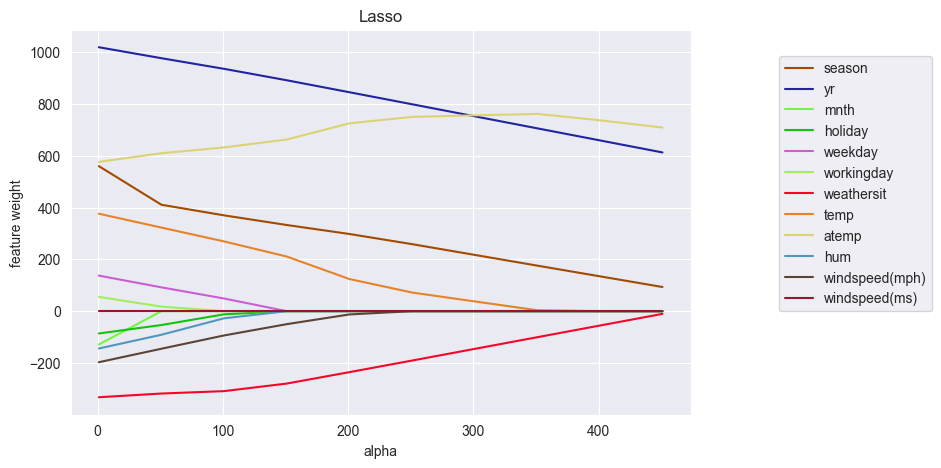

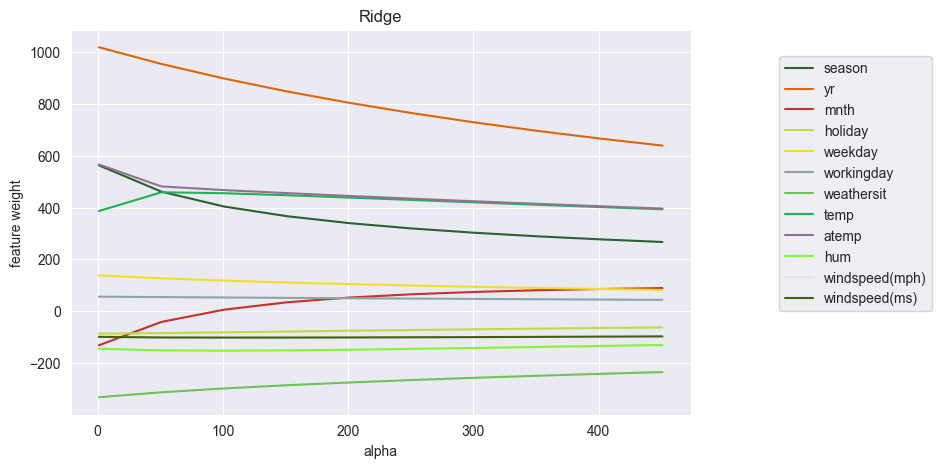

In [17]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

Відповідь:

  1.Ridge регуляризатор менш агресивно зменшує ваги при збільшенні значення альфа в порівнянні з Lasso.
  
  2.Якщо альфа зробити дуже великим для Lasso, ваги всіх ознак зійдуть на нуль. Це відбувається через те, що Lasso накладає L1-норму на ваги, яка схильна робити деякі ваги точно нульовими при високому рівні регуляризації.
  
  3.Так, можна стверджувати, що Lasso виключає одну з ознак windspeed при будь-якому значенні alpha > 0. Вага windspeed(ms) практично дорівнює нулю при всіх значеннях альфа. Ridge, на відміну від Lasso, не виключає ознаки повністю, його ваги зменшуються поступово, але не стають нульовими.
  
  4.Lasso підійде для відбору неінформативних ознак, оскільки він схильний до встановлення нульових ваг для ознак, які менше впливають на цільову змінну

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [18]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

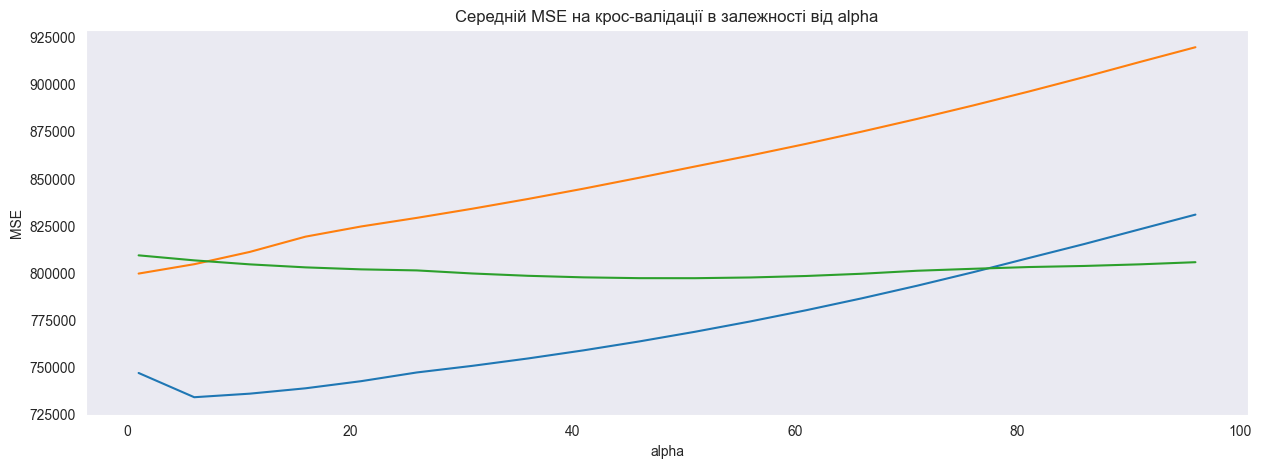

season: 532.0189828413535
yr: 1015.0602226430595
mnth: -100.03952614356629
holiday: -83.29395987529904
weekday: 132.50446549095795
workingday: 51.557085614073735
weathersit: -330.5598567399817
temp: 370.67985503003405
atemp: 581.396931065498
hum: -140.00740550068844
windspeed(mph): -191.77140847135036
windspeed(ms): -2.6854702314758792e-08
Вибране значення alpha: 6


In [19]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3)
regressor.fit(X, y)
mse_paths = regressor.mse_path_
plot_data = list(zip(regressor.alphas_, mse_paths))
create_plot(plot_data, 'Середній MSE на крос-валідації в залежності від alpha', 'alpha', 'MSE')

for feature, coef in zip(df.columns[:-1], regressor.coef_):
    print(f"{feature}: {coef}")
    
print("Вибране значення alpha:", regressor.alpha_)

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Alpha = 6, MSE = 733725.7604052245
Alpha = 1, MSE = 799433.1673691699
Alpha = 51, MSE = 796979.8955193633


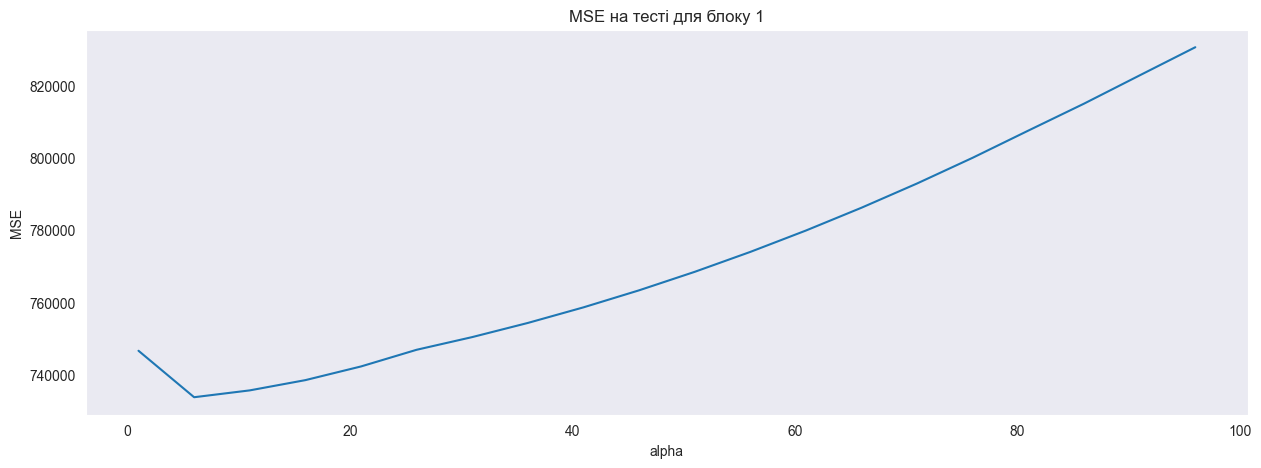

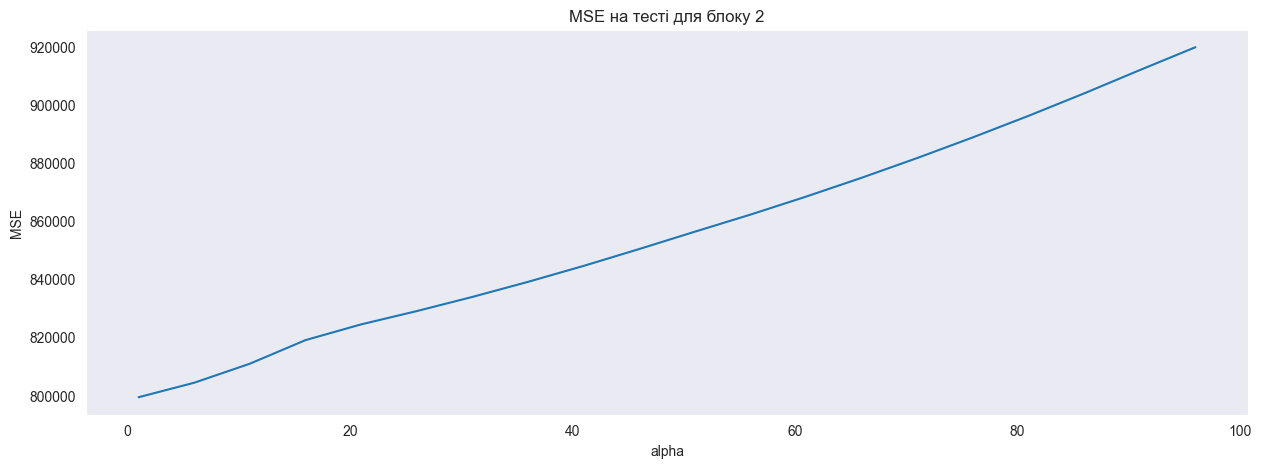

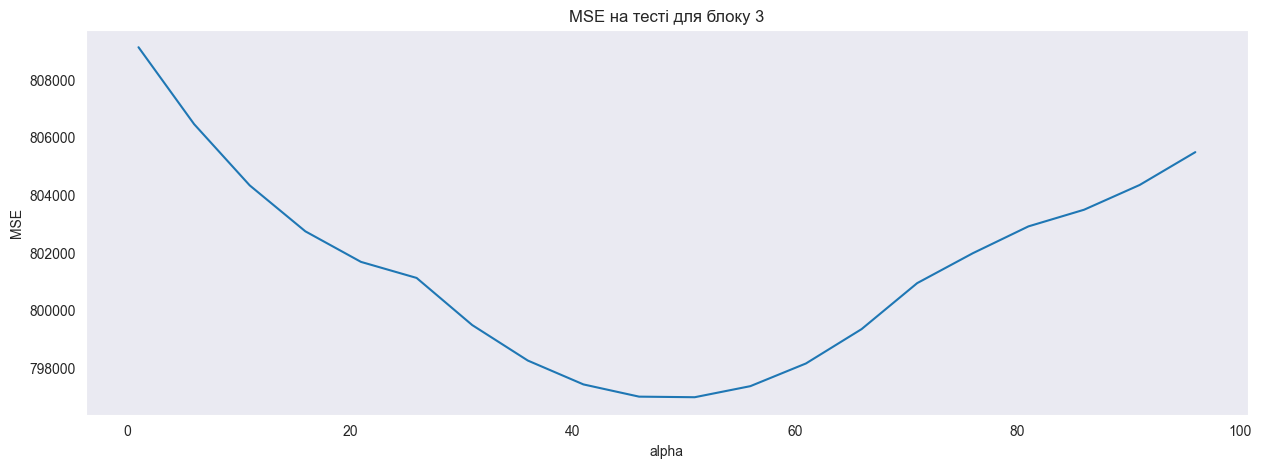

In [20]:
regressor_alphas = regressor.alphas_  # Значення alphas

for i in range(mse_paths.shape[1]):
    min_mse_idx = np.argmin(mse_paths[:, i])
    print(f"Alpha = {regressor.alphas_[min_mse_idx]}, MSE = {mse_paths[min_mse_idx, i]}")

for i in range(mse_paths.shape[1]):
    plt.figure(figsize=(15, 5))
    plt.plot(regressor_alphas, mse_paths[:, i])
    plt.title(f'MSE на тесті для блоку {i + 1}')
    plt.xlabel('alpha')
    plt.ylabel('MSE')
    plt.grid()
    plt.show()

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

season: Високий позитивний коефіцієнт  532.01898 вказує на те, що певні сезони сприяють збільшенню кількості орендованих велосипедів.

yr: Значення 1015.06022 вказує на те, що з кожним роком попит на велосипеди збільшується.

temp: Коефіцієнт 370.67986 свідчить про те, що з підвищенням температури кількість орендованих велосипедів також зростає.

atemp: Аналогічно до температури, цей коефіцієнт 581.39693 вказує на те, що вища відчутна температура також сприяє збільшенню попиту на велосипеди.

Зростаючу лінійну залежність `cnt` видно лише від `yr`.

Не логічно стверджувати що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди, виходячи зі здорового глузду ми розуміємо що в сезони з холодним кліматом попит на велосипеди зменшується, аналогічно й коли занадто висоеа температура.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

weathersit: -330.55986
hum: -140.00741
windspeed(mph): -191.77141

В цих ознаках видніється лінійна залежність що зменшується.

Логічно стверджувати що чим більші ці ознаки тим гірші погодні умови отже менше людей захоче взяти велосипед 

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

В нас лише одна ознака приблидена до нуля це windspeed(ms): -0.0000000269.Модель виключила її з моделі тому що вона ідентична з ознакою windspeed(mph).Взагалі ця ознака впливає на попит на велосипедиб але так як в нас є ознака windspeed(mph) то windspeed(ms) нам не потрібна для аналізу

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.